## Linear regression model for car price forecasting

Importing all necessary modules

In [1069]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools as it


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce

import eli5
from eli5.sklearn import PermutationImportance

import seaborn as sns
sns.set()

# Data cleanzing and transforming functions

In [1070]:
def outliers_remove(dataset,train):
    
#remove outliers based on interquantile range
        
    iqr=train['Price'].quantile(0.75)-train['Price'].quantile(0.25)
    dataset=dataset[dataset['Price']<=train['Price'].quantile(0.75)+iqr*1.5]
    dataset=dataset[dataset['Price']>=train['Price'].quantile(0.25)-iqr*1.5]
        
    return dataset


In [1071]:
def leverage_remove(dataset, dataset_train):

#remove observations with high leverage
    
    y_to_transform=dataset.Price
    X_train=dataset_train.drop('Price',axis=1)
    X_to_transform=dataset.drop('Price',axis=1)
    
    X_to_transform=numerical_preprocessor(X_to_transform, X_train)

    X_lev=X_to_transform.select_dtypes(['float64','int64'])
    model_lev = sm.OLS(y_to_transform, sm.add_constant(X_lev)).fit()

    influence = model_lev.get_influence()
    leverage = influence.hat_matrix_diag
    inf_sum = influence.summary_frame()

    price_res = pd.concat([y_to_transform, inf_sum], axis = 1)
    price_res=price_res.rename(columns={'hat_diag': 'leverage'})

    l = price_res.leverage
    print ('High leverage:',price_res.Price[abs(l) > ((X_to_transform.shape[1])+1)/X_to_transform.shape[0]].count())
    leverage =price_res.Price[abs(l) > ((X_to_transform.shape[1])+1)/X_to_transform.shape[0]]

    leverage_index = leverage.index
    data_index = dataset.index

    data=dataset[data_index.isin(leverage_index)==False]


    return data

In [1072]:
def columns_numerical(X_train):
    return [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [1073]:
def columns_categorical(X_train):
    return [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                            X_train[cname].dtype == "object"and cname.find('target')<0 and cname.find("_") < 0]

In [1074]:
def columns_target(X_train):
    return [cname for cname in X_train.columns if X_train[cname].dtype == "object" and X_train[cname].nunique() >= 10 or
            cname.find("_") > 0]

In [1075]:
def numerical_preprocessor(X_to_transform, X_train):
    
    # Select numerical columns
    numerical_cols = columns_numerical(X_train)

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    
    X_transformed=X_to_transform.copy()
    numerical_transformer.fit(X_train[numerical_cols])
    
    X_transformed[numerical_cols]=numerical_transformer.transform(X_to_transform[numerical_cols])
    
    return X_transformed

In [1076]:
def big_categorical_preprocessor (X_train, y_train):
    
    # Select categorical columns with relatively high cardinality 

    big_categorical_cols_target = columns_target(X_train)
    
    
    # Preprocessing
    big_categorical_transformer_target=ce.TargetEncoder(cols=big_categorical_cols_target)
    
    
    X_transformed=X_train.copy()
    X_transformed[big_categorical_cols_target]=big_categorical_transformer_target.fit_transform(X_train[big_categorical_cols_target], y_train)
    return X_transformed

In [1077]:
def pipeline_preprocessing(X_train):
    
    # Select categorical columns with relatively low and high cardinality 
    
    categorical_cols = columns_categorical(X_train)

    big_categorical_cols_target = columns_target(X_train)
    
    # Select numerical columns
    numerical_cols = columns_numerical(X_train)

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])



    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(sparse=False, drop='first')

    big_categorical_transformer_target=ce.TargetEncoder()


    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('big_cat_target',big_categorical_transformer_target, big_categorical_cols_target)])
    
    return preprocessor

# Features functions

In [1078]:
def multicolinearity_check(X):
    
    X=numerical_preprocessor(X,X)
    variables=X.select_dtypes(['float64','int64'])
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif["features"] = variables.columns
    return vif

In [1079]:
def create_interactions(dataset):
    cat_features = dataset.select_dtypes('object').columns
    name=""
    
    for item in it.combinations(cat_features, 2):
        name=item[0]+"_"+item[1]
        dataset[name]=dataset[item[0]].astype('str')+"_"+dataset[item[1]].astype('str')
    
    
    return dataset

In [1080]:
def features_importance(X_train, y_train):
    
    model=LinearRegression()
    X_tocheck=X_train.select_dtypes(['float64','int64'])

    model.fit(X_tocheck, y_train)
    perm = PermutationImportance(model, random_state=0).fit(X_tocheck, y_train)
    return eli5.show_weights(perm, feature_names = X_tocheck.columns.tolist())
    

# Modeling fucntions

Fit OLS model from statsmodel to check regression summary

In [1081]:
def OLS_with_summary(X_train, y_train):
    
    X_train_OLS = pd.get_dummies(X_train, drop_first=True)
    
    
    X = sm.add_constant(X_train_OLS)
    model_OLS = sm.OLS(y_train,X)
    results = model_OLS.fit()
    
    #return linear regression summary
    return results.summary()

Fit sklearn pipeline with linear regression

In [1082]:
def pipeline_fit(X_train,y_train):
                            
    preprocessor=pipeline_preprocessing(X_train)
    model=LinearRegression()
    
    
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

    # Preprocessing of training data, fit model 
    my_pipeline=my_pipeline.fit(X_train, y_train)
    print('R2: {}, Intercept: {}'.format(my_pipeline.score(X_train, y_train).round(decimals=3), my_pipeline.named_steps['model'].intercept_.round(decimals=3)))
    return my_pipeline

In [1083]:
def predictions(X_train, y_train, X_test, y_test):
    
    pipeline=pipeline_fit(X_train,y_train)

    # Preprocessing of validation data, get predictions
    preds = pipeline.predict(X_test)    

    #Create data frame with predictions and residuals
    predictions=pd.DataFrame(np.exp(preds), columns=['Prediction'])
    y_test = y_test.reset_index(drop=False)
   
    
    predictions['Car_index']=y_test['index']
    predictions['Target']=np.exp(y_test['Price'])
    predictions['Residuals']=predictions['Target']-predictions['Prediction']
    predictions['Difference%'] = np.absolute(predictions['Residuals']/predictions['Target']*100)
    
    # Evaluate the model
    score = mean_absolute_error(predictions['Target'], predictions['Prediction'])
    MAPE=np.abs(predictions['Residuals']).sum()/predictions['Target'].sum()*100
    
    print('MAE:', score.round(decimals=2))
    print('MAPE: {}%'.format(MAPE.round(decimals=2)))
    
    return predictions


Import dataset

In [1084]:
data = pd.read_csv('1.04. Real-life example.csv')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


There are 4 numeric and 5 categorical variables. Target column - Price - contains missing values, so we need to remove them.
Also there are missed values in "EngineV" column - it'll be handled with help of SimpleImputer (mean strategy). 

In [1085]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [1086]:
data.dropna(subset=['Price'],axis=0,inplace=True)
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4173,4173.000000,4173,4173.000000,4025.000000,4173,4173,4173.000000,4173
unique,7,NaN,6,NaN,NaN,4,2,NaN,310
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,908,NaN,1604,NaN,NaN,1903,3779,NaN,193
mean,NaN,19418.746935,NaN,164.088426,2.764586,NaN,NaN,2006.367362,NaN
std,NaN,25584.242620,NaN,104.823056,4.935941,NaN,NaN,6.686728,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [1087]:
# Replace incorrect values of engine volume on NaN (higher than 7 litres)
data['EngineV']=data['EngineV'].apply(lambda x: [None if x > 7 else x][0])

#Convert 'Registration' to boolean
data['Registration']=data['Registration'].replace({'yes':True,'no':False})

data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4173,4173.000000,4173,4173.000000,4003.000000,4173,4173,4173.000000,4173
unique,7,NaN,6,NaN,NaN,4,2,NaN,310
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,True,NaN,E-Class
freq,908,NaN,1604,NaN,NaN,1903,3779,NaN,193
mean,NaN,19418.746935,NaN,164.088426,2.467732,NaN,NaN,2006.367362,NaN
std,NaN,25584.242620,NaN,104.823056,0.975549,NaN,NaN,6.686728,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


Below we can see that price has exponential relationship with Year and Mileage. So log transformation for target variable can be applied. There are visible several outliers which should be removed.

G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


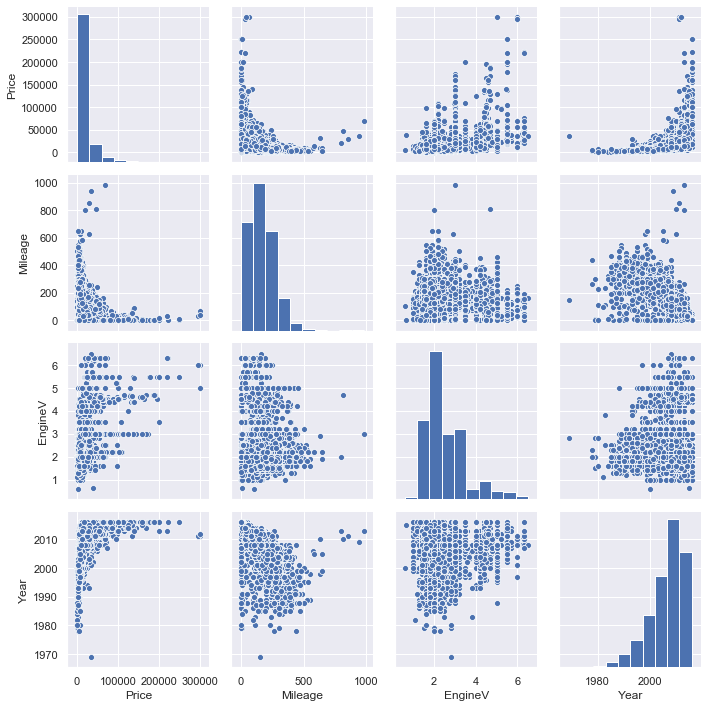

In [1088]:
sns.pairplot(data.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout();

Create X and y variables, test and train samples.

In [1089]:
y=data.Price
X=data.drop(['Price'], axis=1)

In [1090]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [1091]:
data_train=data[data.index.isin(X_train.index)]
data_test=data[data.index.isin(X_test.index)]

In [1092]:
# remove outliers and observations with high leverage in the train dataset
data_clean=outliers_remove(data_train,data_train)
data_clean=leverage_remove(data_clean, data_clean)

print(data_clean.describe())

# log transformation for target variable in the train dataset
data_clean['Price']= np.log(data_clean['Price'])

y_train=data_clean.Price
X_train=data_clean.drop(['Price'], axis=1)

G:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


High leverage: 235
              Price      Mileage      EngineV         Year
count   2812.000000  2812.000000  2689.000000  2812.000000
mean   13315.701362   172.173542     2.265433  2006.343528
std     9308.313446    90.559252     0.717059     5.722634
min      800.000000     0.000000     0.600000  1988.000000
25%     6900.000000   108.000000     1.800000  2003.000000
50%    10500.000000   168.000000     2.000000  2007.000000
75%    17596.250000   234.000000     2.600000  2011.000000
max    44000.000000   450.000000     4.800000  2016.000000


In [1093]:
# remove outliers and observations with high leverage in the test dataset
data_clean_test=outliers_remove(data_test, data_train)
data_clean_test=leverage_remove(data_clean_test, data_clean)

print(data_clean_test.describe())

# log transformation for target variable in the test dataset
data_clean_test['Price']= np.log(data_clean_test['Price'])

y_test=data_clean_test.Price
X_test=data_clean_test.drop(['Price'], axis=1)

G:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


High leverage: 58
              Price    Mileage     EngineV         Year
count    707.000000  707.00000  671.000000   707.000000
mean   13271.286181  174.43140    2.306677  2006.186704
std     9083.095922   90.52528    0.731851     5.667780
min     1200.000000    0.00000    1.000000  1989.000000
25%     6900.000000  113.00000    1.800000  2003.000000
50%    10800.000000  168.00000    2.200000  2007.000000
75%    17788.500000  240.00000    2.750000  2011.000000
max    43999.000000  435.00000    4.800000  2016.000000


After outliers/leverage removal and log-transformation of target variable, the relationship between features and target looks more linear and applicable for linear regression model. However, there are still some observations that looks like outliers.

G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


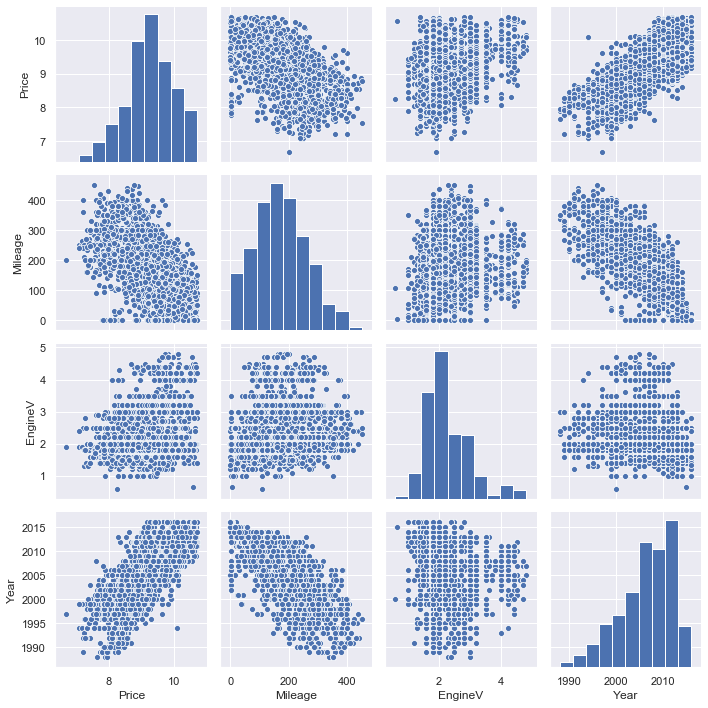

In [1094]:
sns.pairplot(data_clean.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout();

Firstly numerical transformer was applied, then calculate VIF to check multicolinearity. All coefficients are less then 5, so can use all of them further.

In [1095]:
VIF=multicolinearity_check(X_train)
VIF

,VIF,features
0,2.363334,Mileage
1,1.029485,EngineV
2,2.368635,Year


Create variables with iteractions to check influence of potential new variables in the model.

In [1096]:
data_interactions=create_interactions(data_clean)
X_train=data_interactions.drop(['Price'], axis=1)


Transform variables: numerical (SimpleImputer, Scaler) and categorical (TargetEncoder).

In [1116]:
X_train_transformed=numerical_preprocessor(X_train,X_train)
X_train_transformed=big_categorical_preprocessor(X_train_transformed,y_train)

Check features importance with help of PermutationImportance. We can see that 'Model', 'Year' and 'Brand_Model' have the highest weights. There may be strong multicollinearity between 'Model' and 'Brand_Model', so before include features in model let's once more check VIF.

In [1098]:
features_importance(X_train_transformed, y_train)

Weight,Feature
0.9022 ± 0.0313,Model
0.6638 ± 0.0120,Year
0.6230 ± 0.0264,Brand_Model
0.1520 ± 0.0068,Engine Type_Model
0.0976 ± 0.0071,EngineV
0.0389 ± 0.0035,Body_Model
0.0122 ± 0.0018,Brand_Body
0.0043 ± 0.0017,Brand_Engine Type
0.0026 ± 0.0012,Mileage
0.0013 ± 0.0008,Body_Engine Type


We can see below that assumption about multicollinearity was correct. Let's remove all interactions and check once more ('Model' factor has higher weight than 'Brand_Model', so better remove interactions).

In [1099]:
VIF_with_interactions=multicolinearity_check(X_train_transformed)
VIF_with_interactions

,VIF,features
0,2.488947,Mileage
1,1.621440,EngineV
2,2.841727,Year
3,1473.627432,Model
4,4.731799,Brand_Body
5,1.669975,Brand_Engine Type
6,1457.703092,Brand_Model
7,3.315586,Body_Engine Type
8,9.019448,Body_Model
9,6.828820,Engine Type_Model


In [1100]:
X_train_final=X_train_transformed[columns_numerical(X_train)+['Model']]
VIF_final=multicolinearity_check(X_train_final)
VIF_final

,VIF,features
0,2.392321,Mileage
1,1.481859,EngineV
2,2.724120,Year
3,1.825578,Model


In [1101]:
features_importance(X_train_final, y_train)

Weight,Feature
0.6751 ± 0.0343,Year
0.1931 ± 0.0084,Model
0.1265 ± 0.0074,EngineV
0.0073 ± 0.0019,Mileage


There are no multicollinearity between selected factors, so we can use all of them in the regression model.

In [1102]:
# add back categorical variables with low cardinality and boolean 'Registration'
X_train_final=X_train_final.join(X_train[columns_categorical])
X_train_final=X_train_final.join(X_train['Registration'])
X_train_final.head()

,Mileage,EngineV,Year,Model,Brand,Body,Engine Type,Registration
0,1.157751,-0.378611,-2.681677,8.872214,BMW,sedan,Petrol,True
3,0.749106,2.759445,0.114735,10.187074,Audi,crossover,Petrol,True
6,2.935909,-0.378611,-1.633022,8.872214,BMW,sedan,Gas,True
7,0.307328,0.619861,-0.060040,8.962720,Audi,vagon,Diesel,True
8,0.230017,-1.091806,0.988614,9.024858,Renault,vagon,Diesel,True


In [1103]:
X_train_final=X_train.loc[:,X_train_final.columns]
X_train_final.loc[:,'Registration']=X_train_final.loc[:,'Registration'].astype('str')

X_test_final=X_test.loc[:,X_train_final.columns]
X_test_final.loc[:,'Registration']=X_test_final.loc[:,'Registration'].astype('str')

Create regression model with summary. R-squared is high enough, p-values of the model and features are lower 0.05.

In [1104]:
X_train_transformed_final=numerical_preprocessor(X_train_final,X_train_final)
X_train_transformed_final=big_categorical_preprocessor(X_train_transformed_final,y_train)


OLS_with_summary(X_train_transformed_final, y_train)

G:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     1065.
Date:                Fri, 21 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:43:31   Log-Likelihood:                -121.76
No. Observations:                2812   AIC:                             283.5
Df Residuals:                    2792   BIC:                             402.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.7924      0.149     45.439      0.000       6.499       7.085
Mileage                -0.0462      0.008     -5.525      0.000      -0.063      -0.030
EngineV                 0.1309      0.007     20.021      0.000       0.118       0.144
Year                    0.4159      0.009     47.279      0.000       0.399       0.433
Model                   0.2266      0.015     14.734      0.000       0.196       0.257
Brand_BMW               0.0495      0.020      2.533      0.011       0.011       0.088
Brand_Mercedes-Benz    -0.0526      0.020     -2.666      0.008      -0.091      -0.014
Brand_Mitsubishi       -0.3841      0.024    -16.307      0.000      -0.430      -0.338
Brand_Renault          -0.5105      0.023    -22.506      0.000      -0.555      -0.466
Brand_Toyota           -0.2093      0.021     -9.877      0.000      -0.251      -0.168
Brand_Volkswagen       -0.2223      0.019    -11.712      0.000      -0.260      -0.185
Body_hatch             -0.2242      0.027     -8.435      0.000      -0.276      -0.172
Body_other             -0.1239      0.022     -5.674      0.000      -0.167      -0.081
Body_sedan             -0.1647      0.018     -9.066      0.000      -0.200      -0.129
Body_vagon             -0.1840      0.024     -7.803      0.000      -0.230      -0.138
Body_van               -0.2856      0.022    -12.878      0.000      -0.329      -0.242
Engine Type_Gas        -0.0805      0.017     -4.835      0.000      -0.113      -0.048
Engine Type_Other      -0.1019      0.027     -3.764      0.000      -0.155      -0.049
Engine Type_Petrol     -0.0650      0.014     -4.803      0.000      -0.092      -0.038
Registration_True       0.8354      0.017     49.029      0.000       0.802       0.869
==============================================================================
Omnibus:                      383.130   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1572.886
Skew:                          -0.614   Prob(JB):                         0.00
Kurtosis:                       6.452   Cond. No.                         299.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Create the same model with help of sklearn and calculate errors (MAE, MAPE). 

In [1105]:
results=predictions(X_train_final,y_train, X_test_final, y_test)

R2: 0.879, Intercept: 6.792
MAE: 2529.13
MAPE: 19.06%


Mostly errors are lower 26%, however max difference in % shows that there are may be outliers, which not excluded, or important factors, which not included.

In [1106]:
results.describe()

,Prediction,Car_index,Target,Residuals,Difference%
count,707.000000,707.000000,707.000000,707.000000,707.000000
mean,12672.513560,2142.555870,13271.286181,598.772621,20.891930
std,7515.210943,1264.333535,9083.095922,3970.116671,25.775039
min,1466.889186,1.000000,1200.000000,-13548.947205,0.086004
25%,7217.102015,1011.000000,6900.000000,-1334.380132,7.841406
50%,11263.214838,2164.000000,10800.000000,-10.622658,15.621325
75%,16706.632595,3272.000000,17788.500000,1737.665059,25.824131
max,46030.221152,4332.000000,43999.000000,21430.467745,341.737960


Let's check few observation with highest errors.

In [1107]:
print(results.sort_values(by=['Difference%']).tail(10))

       Prediction  Car_index  Target     Residuals  Difference%
423   3655.451074       2560  1800.0  -1855.451074   103.080615
86   11795.861137        512  5000.0  -6795.861137   135.917223
581   3564.429090       3561  1500.0  -2064.429090   137.628606
44   13721.005814        256  5500.0  -8221.005814   149.472833
124   6819.374587        663  2700.0  -4119.374587   152.569429
193  21948.947205       1127  8400.0 -13548.947205   161.296991
74    5274.818353        470  1850.0  -3424.818353   185.125316
543   5413.842650       3337  1800.0  -3613.842650   200.769036
220   8456.051277       1330  2300.0  -6156.051277   267.654403
81    5300.855523        499  1200.0  -4100.855523   341.737960


In [1108]:
data[data.index==470]

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
470,Volkswagen,1850.0,vagon,270,1.9,Diesel,True,2000,Passat B5


In [1109]:
data[data.Model=='Passat B5'].describe()

,Price,Mileage,EngineV,Year
count,57.000000,57.000000,54.000000,57.000000
mean,5355.894737,239.140351,1.951852,2001.719298
std,2577.798837,63.711246,0.261881,2.234106
min,1800.000000,1.000000,1.800000,1997.000000
25%,2900.000000,200.000000,1.800000,2000.000000
50%,5700.000000,250.000000,1.900000,2002.000000
75%,7700.000000,279.000000,1.900000,2003.000000
max,10200.000000,350.000000,2.800000,2006.000000


In [1110]:
data[data.Model=='Passat B5'].sort_values(by=['Price']).head(10)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
1396,Volkswagen,1800.0,other,280,1.9,Diesel,False,1997,Passat B5
470,Volkswagen,1850.0,vagon,270,1.9,Diesel,True,2000,Passat B5
1958,Volkswagen,2200.0,sedan,279,1.9,Diesel,False,2000,Passat B5
646,Volkswagen,2200.0,sedan,272,1.9,Diesel,False,1998,Passat B5
565,Volkswagen,2200.0,sedan,180,1.9,Diesel,False,2003,Passat B5
2202,Volkswagen,2300.0,vagon,200,1.9,Diesel,False,1999,Passat B5
1212,Volkswagen,2350.0,sedan,11,1.9,Other,False,2000,Passat B5
212,Volkswagen,2350.0,sedan,300,1.9,Diesel,False,1998,Passat B5
2309,Volkswagen,2400.0,vagon,320,1.9,Diesel,False,2000,Passat B5
2015,Volkswagen,2499.0,sedan,220,1.9,Diesel,False,2004,Passat B5


#### Visual analysis of residuals and forecast

There are some observations that look like outliers. The pattern on the chart doesn't look perfectly random. So maybe better apply different configuration of the model or other method. Residuals are more disperced for lower targets (heteroscedasticity?).

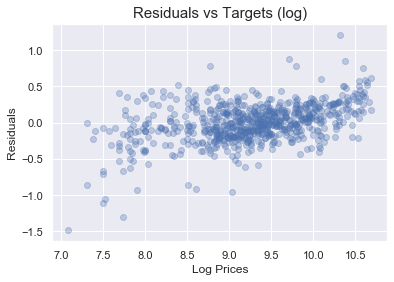

In [1111]:
plt.scatter(np.log(results['Target']),np.log(results['Target'])-np.log(results['Prediction']),alpha=0.3)
plt.xlabel('Log Prices',size=12)
plt.ylabel('Residuals',size=12)
plt.title('Residuals vs Targets (log)',size=15);

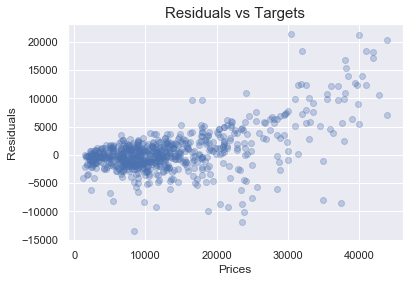

In [1112]:
plt.scatter(results['Target'],results['Residuals'],alpha=0.3)
plt.xlabel('Prices',size=12)
plt.ylabel('Residuals',size=12)
plt.title('Residuals vs Targets',size=15);

Histogram of the residuals looks like normally distributed, but with high skewness.

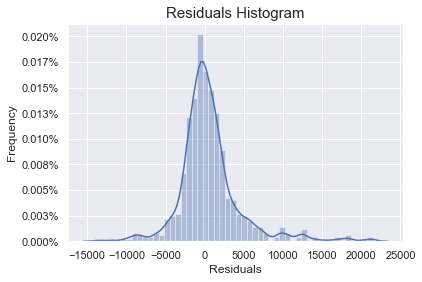

In [1113]:
fig, ax = plt.subplots()
sns.distplot(results['Residuals'])
plt.ylabel('Frequency',size=12)
plt.title('Residuals Histogram',size=15)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=3));

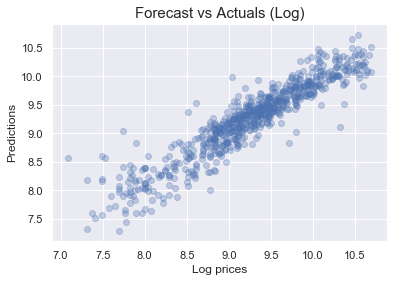

In [1114]:
plt.scatter(np.log(results['Target']),np.log(results['Prediction']),alpha=0.3)
plt.xlabel('Log prices',size=12)
plt.ylabel('Predictions',size=12)
plt.title('Forecast vs Actuals (Log)', size=15);


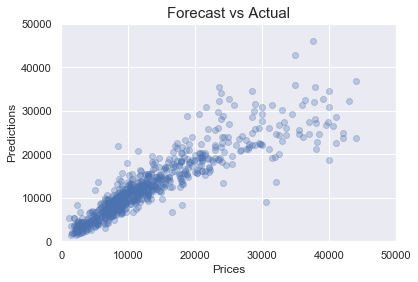

In [1115]:
plt.scatter(results['Target'],results['Prediction'],alpha=0.3)
plt.xlabel('Prices',size=12)
plt.ylabel('Predictions',size=12)
plt.title('Forecast vs Actual',size=15)
plt.xlim(0,50000)
plt.ylim(0,50000);